# Machine Learning Models for Text Classification  

In this notebook, we will train and evaluate different **Machine Learning models** for **text classification** using the **TF-IDF features** extracted in the previous steps.  

We will use the **TF-IDF matrix (`Xtrain_matrix.pkl`)** as input features and the **target labels (`y_train_encoded.pkl`)** for supervised learning.  
The **test dataset (`Xtest_matrix.pkl`)** will not be used at this stage, as it is reserved for **final result submission**.  

We will start by experimenting with the following models:  
- **Logistic Regression**  
- **Support Vector Machines (SVM)**  
- **Random Forest Classifier**  
- **K-Neighbors Classifier**  
- **Decision Tree Classifier**
- **Linear SVC** 
- **XGBoost**  
- **Voting Classifier**  

📌 **These models have been selected based on standard text classification approaches, but we may adjust our choices depending on their performance.**  

### **Hyperparameter Search Strategy**  
Instead of a more comprehensive search, we will perform a **targeted hyperparameter tuning** using **GridSearchCV**, selecting only the most impactful hyperparameters.  
This approach allows us to improve model performance while **keeping training time manageable**.  
Further hyperparameter tuning and more complex models (such as RNNs and deep learning approaches) will be explored in future iterations.  
  

By the end of this notebook, we will:  
✔ Compare the performance of different models  
✔ Select and save the best-performing model for future use  
✔ Display the correspondence between the **encoded labels** (0-26) and their **original product code classes** with their labels to analyze predictions  
✔ Identify categories classified at or **above the baseline (F1-score > 0.80**) and detect those **significantly misclassified (F1-score < 0.50)**.

## 1. Import Required Libraries 

In [71]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import os
from pathlib import Path
import pickle
import pandas as pd
from joblib import dump, load
# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Setting Up Project Paths and Configurations

In [72]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 2 levels)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py

Project Root Directory: Data_Scientist_Rakuten_Project-main


## 2. Loading Preprocessed Data  

Before training our Machine Learning models, we need to load the **TF-IDF matrix (`Xtrain_matrix.pkl`)** and the **target labels (`ytrain.pkl`)**.  


In [73]:
# Paths to load
tfidf_path = Path(config.XTRAIN_MATRIX_PATH)
labels_path = Path(config.YTRAIN_ENCODED_PATH)

# Print paths being used (relative to project root)
print(f"Using Config File from: {get_relative_path(config.__file__)}")
print(f"Loading TF-IDF matrix from: {get_relative_path(tfidf_path)}")
print(f"Loading encoded labels from: {get_relative_path(labels_path)}")

# Check if files exist before loading
if not tfidf_path.exists():
    raise FileNotFoundError(f"Error: TF-IDF matrix file not found at {get_relative_path(tfidf_path)}")

if not labels_path.exists():
    raise FileNotFoundError(f"Error: Encoded labels file not found at {get_relative_path(labels_path)}")

# Load the TF-IDF matrix
X = pickle.load(open(tfidf_path, "rb"))

# Load the classification labels
y = pd.read_pickle(labels_path)

# Print confirmation
print("Data Successfully Loaded!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Using Config File from: config.py
Loading TF-IDF matrix from: data\processed\text\Xtrain_matrix.pkl
Loading encoded labels from: data\processed\text\y_train_encoded.pkl
Data Successfully Loaded!
X shape: (84916, 5000)
y shape: (84916,)


## 3. Splitting Data into Training and Validation Sets

In [74]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Split Completed:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Split Completed:
X_train shape: (67932, 5000), y_train shape: (67932,)
X_test shape: (16984, 5000), y_test shape: (16984,)


## 4. Training Machine Learning Models  

### 4.1 Logistic Regression

To optimize the **Logistic Regression** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score** to handle class imbalances effectively:

- `multi_class`: Set to `'multinomial'` to explicitly handle multi-class classification.  
- `class_weight`: Balances class distribution to mitigate the impact of imbalanced data (`'balanced'` or `None`).  
- `max_iter`: Controls the number of iterations for model convergence, tested with values `[500, 1000, 1500]`.  

Other hyperparameters such as `C` (regularization strength) and `solver` (optimization algorithm) are left to their default values in this setup.


- **GridSearchCV** for Logistic Regression

In [5]:
%%time

# Define a simplified parameter grid
param_grid = {
    'multi_class': ['multinomial'],  # Use 'multinomial' for multi-class classification
    'class_weight': ['balanced', None],  # Balanced or no class weighting
    'max_iter': [500, 1000, 1500],  # Number of iterations for convergence
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_log_reg = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Logistic Regression: {grid_search.best_params_}")

Best Hyperparameters for Logistic Regression: {'class_weight': None, 'max_iter': 500, 'multi_class': 'multinomial'}
Wall time: 2min 13s


- **Re-train** Logistic Regression with the best hyperparameters.

# TO DEL

Wall time: 30.7 s


LogisticRegression(max_iter=500, multi_class='multinomial')

In [12]:
%%time

# After GridSearchCV has finished
# Retrain Logistic Regression with the best hyperparameters
clf_lr = LogisticRegression(
    multi_class=grid_search.best_params_['multi_class'],  # Best 'multi_class' parameter
    class_weight=grid_search.best_params_['class_weight'],  # Best 'class_weight' parameter
    max_iter=grid_search.best_params_['max_iter'],  # Best 'max_iter' parameter
    # Removing 'C' and 'solver' as we're not using them in the simplified grid
)
clf_lr.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"multi_class: {grid_search.best_params_['multi_class']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}")


NameError: name 'grid_search' is not defined

- **Evaluate** Logistic Regression with the best hyperparameters.

In [9]:
# Evaluate Logistic Regression model
y_pred = clf_lr.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = clf_lr.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Logistic Regression:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()



NameError: name 'clf_lr' is not defined

- **Save** the best Logistic Regression model.

In [8]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best Logistic Regression model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Define the full path for saving the model
    model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.pkl")

    # Try to save the trained Logistic Regression model
    with open(model_path, "wb") as f:
        pickle.dump(best_log_reg, f)

    print("Best Logistic Regression model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best Logistic Regression model saved successfully.


###  4.2 Support Vector Machines (SVM)

To optimize the **Support Vector Machines (SVM)** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `kernel`: Specifies the kernel type used in the algorithm. The tested values are `rbf`, `poly`, and `sigmoid`, allowing the model to adapt to different data distributions.  
- `gamma`: Defines the kernel coefficient, applicable **only** to `rbf`, `poly`, and `sigmoid` kernels. The tested values are `[0.01, 0.1, 1, 10]`, enabling exploration of different scaling factors to adjust the influence of individual data points.  

Other hyperparameters are left to their default values in this setup.


- **GridSearchCV** for SVM

In [9]:
%%time

# Define parameter grid for SVM
# Updated hyperparameter grid for SVM
param_grid = {
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Kernels that use gamma
    'gamma': [0.01, 0.1, 1, 10],  # Kernel coefficient
}

# Initialize the SVM model
svm = SVC()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_svm = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for SVM: {grid_search.best_params_}")


Best Hyperparameters for SVM: {'gamma': 1, 'kernel': 'rbf'}
Wall time: 1h 15min 42s


- **Re-train** SVM with the best hyperparameters.

In [10]:
%%time

# After GridSearchCV has finished

best_svm = SVC(
    kernel=grid_search.best_params_['kernel'],
    gamma=grid_search.best_params_['gamma']
)
best_svm.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"Kernel: {grid_search.best_params_['kernel']}\n"
      f"Gamma: {grid_search.best_params_['gamma']}")


Model retrained with the following best hyperparameters:
Kernel: rbf
Gamma: 1
Wall time: 9min 4s


- **Evaluate** SVM with the best hyperparameters.

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.35      0.51      0.41       666
           1       0.52      0.78      0.63       946
           2       0.81      0.80      0.81       369
           3       0.66      0.72      0.69      1002
           4       0.78      0.62      0.69       546
           5       0.90      0.91      0.91       960
           6       0.77      0.70      0.74       479
           7       0.82      0.84      0.83      1013
           8       0.74      0.48      0.58       432
           9       0.89      0.91      0.90       844
          10       0.78      0.67      0.72       966
          11       0.75      0.74      0.75       545
          12       0.96      0.97      0.97      2046
          13       0.85      0.48      0.62       163
          14       0.93      0.87      0.90      1055
          15       0.75      0.71      0.73       268
          16       0.85      0.79      0.82       

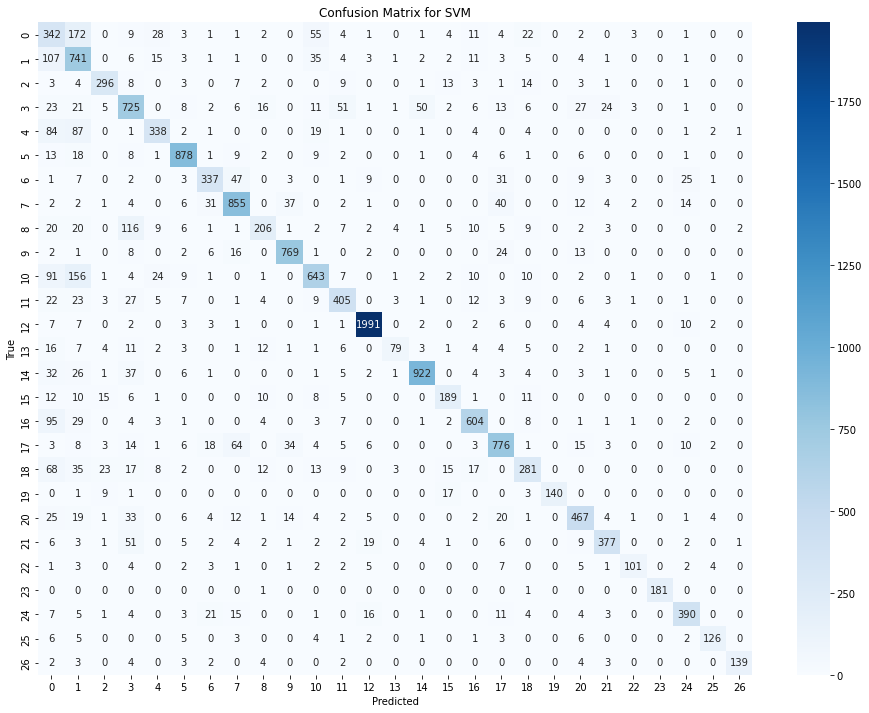

In [11]:
# Evaluate SVM model
y_pred = best_svm.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_svm.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for SVM:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM")
plt.show()


- **Save** the best SVM model.

In [12]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best SVM model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained SVM model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_svm_model.pkl"), "wb") as f:
        pickle.dump(best_svm, f)
    print("Best SVM model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best SVM model saved successfully.


###  4.3 Random Forest Classifier

To optimize the **Random Forest Classifier** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `max_features`: The number of features to consider when looking for the best split. The tested values are `'sqrt'` and `'log2'`, impacting model performance and computational efficiency.  
- `min_samples_split`: The minimum number of samples required to split an internal node. The tested values are `[2, 4, 8]`, helping to control overfitting by requiring a larger sample size before splitting.  

Other hyperparameters, such as `n_estimators`, `max_depth`, `min_samples_leaf`, `class_weight`, and `bootstrap`, are left to their default values in this setup.


- **GridSearchCV** for Random Forest

In [13]:
%%time

# Define parameter grid for Random Forest
param_grid = {
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split (keeping 'sqrt' and adding 'log2' for comparison)
    'min_samples_split': [2, 4, 8],  # Minimum samples required to split a node (keeping 4 and adding 8 for a larger split threshold)
}

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_rf = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Random Forest: {grid_search.best_params_}")


Best Hyperparameters for Random Forest: {'max_features': 'log2', 'min_samples_split': 4}
Wall time: 9min 11s


- **Re-train** Random Forest with the best hyperparameters.

In [14]:
%%time

# After GridSearchCV has finished
# Retrain Random Forest with the best hyperparameters
best_rf = RandomForestClassifier(
    min_samples_split=grid_search.best_params_['min_samples_split'],
    max_features=grid_search.best_params_['max_features']
)
best_rf.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"min_samples_split: {grid_search.best_params_['min_samples_split']}\n"
      f"max_features: {grid_search.best_params_['max_features']}")


Model retrained with the following best hyperparameters:
min_samples_split: 4
max_features: log2
Wall time: 3min 21s


- **Evaluate** Random Forest with the best hyperparameters.

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.36      0.52      0.42       666
           1       0.61      0.74      0.67       946
           2       0.86      0.70      0.77       369
           3       0.66      0.61      0.63      1002
           4       0.74      0.61      0.67       546
           5       0.85      0.91      0.88       960
           6       0.78      0.65      0.71       479
           7       0.76      0.84      0.79      1013
           8       0.68      0.50      0.58       432
           9       0.90      0.90      0.90       844
          10       0.72      0.70      0.71       966
          11       0.71      0.74      0.73       545
          12       0.90      0.98      0.94      2046
          13       0.80      0.50      0.62       163
          14       0.80      0.87      0.83      1055
          15       0.70      0.74      0.72       268
          16       0.80      0.81      0

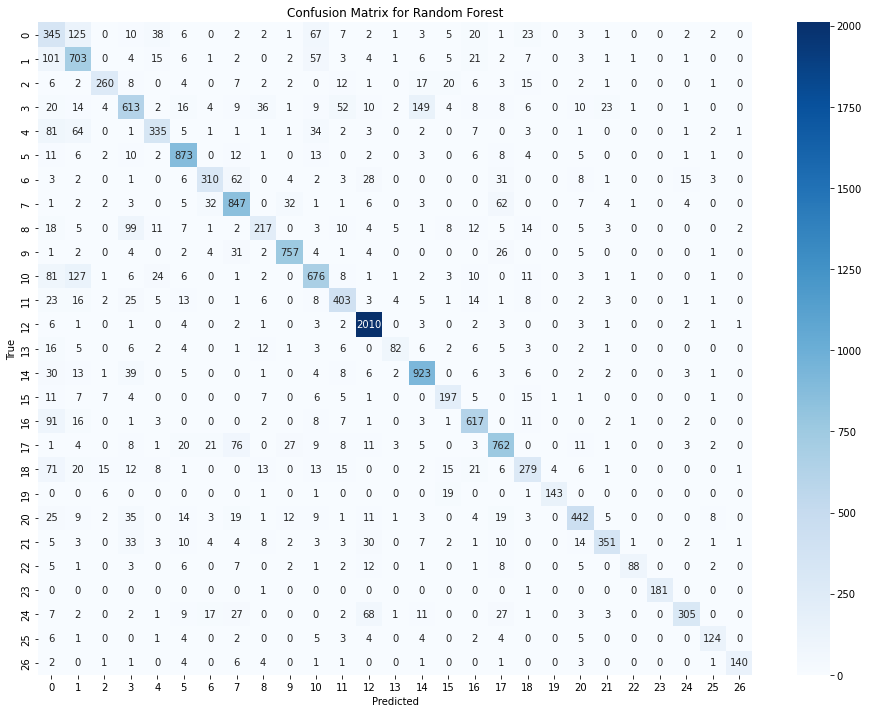

In [15]:
# Evaluate Random Forest model
y_pred = best_rf.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_rf.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Random Forest:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Random Forest")
plt.show()


- **Save** the best Random Forest model.

In [16]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best Random Forest model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Random Forest model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_rf_model.pkl"), "wb") as f:
        pickle.dump(best_rf, f)
    print("Best Random Forest model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best Random Forest model saved successfully.


### 4.4 K-Neighbors Classifier

To optimize the **K-Neighbors Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `n_neighbors`: The number of neighbors to use for knearest neighbors classification. Increasing this value makes the model more general and reduces overfitting.
- `weights`: Function used to weight the points in the neighborhood. Options include `uniform` (all points are weighted equally) or `distance` (closer points have more influence).
- `algorithm`: The algorithm used to compute the nearest neighbors (`auto`, `ball_tree`, `kd_tree`, `brute`).
- `leaf_size`: The leaf size for the `ball_tree` and `kd_tree` algorithms. A smaller leaf size can improve search time.
- `p`: The power parameter for the Minkowski distance. When `p=2`, this corresponds to the Euclidean distance.
- `metric`: The distance metric to use. Can be `minkowski`, `manhattan`, `chebyshev`, or `cosine`.


- **GridSearchCV** for K-Neighbors

In [5]:
%%time

# Define parameter grid for K-Neighbors Classifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function for neighbors
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute nearest neighbors
    'leaf_size': [20, 30, 40],  # Leaf size for 'ball_tree' and 'kd_tree'
    'p': [1, 2],  # Power parameter for Minkowski distance (1 = Manhattan, 2 = Euclidean)
    'metric': ['minkowski', 'manhattan', 'chebyshev', 'cosine']  # Distance metric
}

# Initialize the K-Neighbors Classifier
knn = KNeighborsClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_knn = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for K-Neighbors Classifier: {grid_search.best_params_}")

C:\anaconda_install\envs\data_science\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
864 fits failed out of a total of 2304.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda_install\envs\data_science\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda_install\envs\data_science\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "C:\anaconda_install\envs\data_science\lib\site-packages\sklearn\neighbors\_base.py", line 508, in _fit
    raise ValueError(


Best Hyperparameters for K-Neighbors Classifier: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'cosine', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Wall time: 9h 45min 40s


- **Re-train** K-Neighbors Classifier with the best hyperparameters.

In [6]:
%%time

# After GridSearchCV has finished
# Retrain K-Neighbors Classifier with the best hyperparameters
best_knn = KNeighborsClassifier(
    n_neighbors=grid_search.best_params_['n_neighbors'],
    weights=grid_search.best_params_['weights'],
    algorithm=grid_search.best_params_['algorithm'],
    leaf_size=grid_search.best_params_['leaf_size'],
    p=grid_search.best_params_['p'],
    metric=grid_search.best_params_['metric']
)
best_knn.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_neighbors: {grid_search.best_params_['n_neighbors']}\n"
      f"weights: {grid_search.best_params_['weights']}\n"
      f"algorithm: {grid_search.best_params_['algorithm']}\n"
      f"leaf_size: {grid_search.best_params_['leaf_size']}\n"
      f"p: {grid_search.best_params_['p']}\n"
      f"metric: {grid_search.best_params_['metric']}")

Model retrained with the following best hyperparameters:
n_neighbors: 9
weights: distance
algorithm: auto
leaf_size: 20
p: 1
metric: cosine
Wall time: 11.7 ms


- **Evaluate** K-Neighbors Classifier with the best hyperparameters.

Classification Report for K-Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.30      0.36      0.32       639
           1       0.49      0.55      0.52       952
           2       0.74      0.64      0.68       313
           3       0.61      0.47      0.53       948
           4       0.39      0.19      0.26       562
           5       0.87      0.84      0.85       983
           6       0.82      0.66      0.73       514
           7       0.82      0.76      0.79      1012
           8       0.48      0.39      0.43       405
           9       0.89      0.91      0.90       870
          10       0.60      0.62      0.61       973
          11       0.62      0.68      0.65       515
          12       0.94      0.97      0.95      2047
          13       0.69      0.52      0.59       149
          14       0.55      0.87      0.67      1032
          15       0.63      0.72      0.67       303
          16       0.69      0.

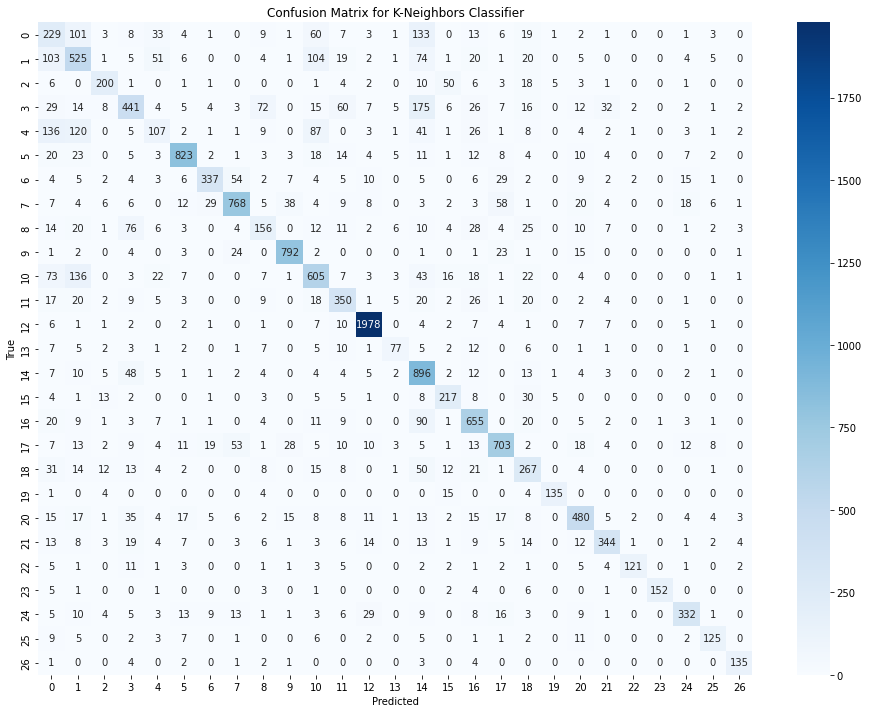

In [7]:
# Evaluate K-Neighbors Classifier model
y_pred = best_knn.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for K-Neighbors Classifier:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_knn.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for K-Neighbors Classifier:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for K-Neighbors Classifier")
plt.show()

- **Save** the best K-Neighbors model.

In [8]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best K-Neighbors model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained K-Neighbors model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_knn_model.pkl"), "wb") as f:
        pickle.dump(best_knn, f)
    print("Best K-Neighbors model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best K-Neighbors model saved successfully.


### 4.5 Decision Tree Classifier

To optimize the **Decision Tree Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `max_depth`: The maximum depth of the tree. Limiting the depth helps to prevent overfitting.
- `min_samples_split`: The minimum number of samples required to split an internal node. This can control overfitting.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A higher value can smooth the model.
- `max_features`: The number of features to consider when looking for the best split. This can impact model performance and speed.
- `criterion`: The function to measure the quality of a split. Common options include `gini` (Gini impurity) and `entropy` (information gain).
- `class_weight`: Balances the classes for imbalanced data (`balanced`, `None`).
- `splitter`: The strategy used to split at each node. Options include `best` (best split) or `random` (random split)..


- **GridSearchCV** for Decision Tree

In [9]:
%%time

# Define parameter grid for Decision Tree Classifier
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'criterion': ['gini', 'entropy'],  # Quality of a split
    'class_weight': ['balanced', None],  # Handle class imbalance
    'splitter': ['best', 'random']  # Strategy for splitting nodes
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_dt = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Decision Tree: {grid_search.best_params_}")


Best Hyperparameters for Decision Tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Wall time: 2min 21s


- **Re-train** Decision Tree with the best hyperparameters.

In [10]:
%%time

# After GridSearchCV has finished
# Retrain Decision Tree with the best hyperparameters
best_dt = DecisionTreeClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features'],
    criterion=grid_search.best_params_['criterion'],
    class_weight=grid_search.best_params_['class_weight'],
    splitter=grid_search.best_params_['splitter']
)
best_dt.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"max_depth: {grid_search.best_params_['max_depth']}\n"
      f"min_samples_split: {grid_search.best_params_['min_samples_split']}\n"
      f"min_samples_leaf: {grid_search.best_params_['min_samples_leaf']}\n"
      f"max_features: {grid_search.best_params_['max_features']}\n"
      f"criterion: {grid_search.best_params_['criterion']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"splitter: {grid_search.best_params_['splitter']}")

Model retrained with the following best hyperparameters:
max_depth: None
min_samples_split: 5
min_samples_leaf: 1
max_features: auto
criterion: gini
class_weight: None
splitter: best
Wall time: 2.09 s


- **Evaluate** Decision Tree with the best hyperparameters.

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.27      0.53      0.36       639
           1       0.52      0.57      0.54       952
           2       0.51      0.60      0.55       313
           3       0.48      0.48      0.48       948
           4       0.56      0.45      0.50       562
           5       0.73      0.73      0.73       983
           6       0.54      0.54      0.54       514
           7       0.62      0.64      0.63      1012
           8       0.40      0.36      0.38       405
           9       0.82      0.82      0.82       870
          10       0.68      0.60      0.64       973
          11       0.63      0.62      0.63       515
          12       0.90      0.92      0.91      2047
          13       0.78      0.42      0.54       149
          14       0.82      0.81      0.81      1032
          15       0.67      0.64      0.66       303
          16       0.79      0.74      0

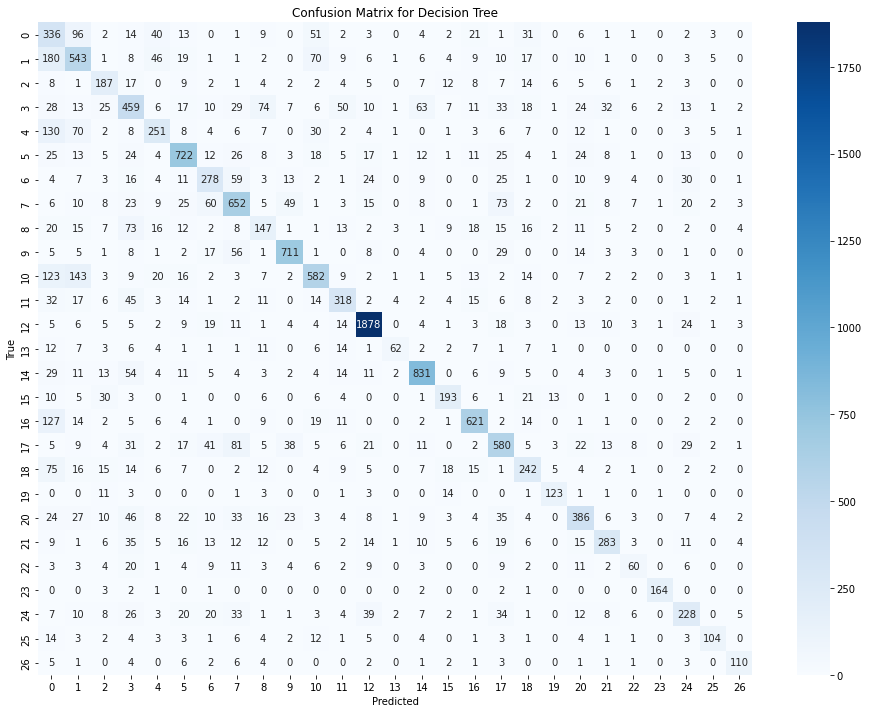

In [11]:
# Evaluate Decision Tree model
y_pred = best_dt.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_dt.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Decision Tree:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

- **Save** the best Decision Tree model.

In [12]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best Decision Tree model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Decision Tree model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_dt_model.pkl"), "wb") as f:
        pickle.dump(best_dt, f)
    print("Best Decision Tree model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best Decision Tree model saved successfully.


###  4.6 Linear SVC

To optimize the **Linear SVC** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `C`: Regularization parameter. The tested values are `[0.4, 0.8, 1.6]`, where lower values encourage simpler models, while higher values allow more flexibility.  
- `max_iter`: The maximum number of iterations for the solver to converge. The tested values are `[2000, 4000, 8000]`, ensuring sufficient iterations for convergence, especially for complex data.  
- `penalty`: Specifies the norm used in the penalization. Set to `'l2'`, which is the default and commonly used for Linear SVC.  
- `dual`: A boolean flag to choose between the primal or dual formulation. Set to `True` as per the configuration.  
- `tol`: The tolerance for stopping criteria. The tested values are `[1e-6, 1e-5, 1e-4]`, where lower values improve precision but increase computation time.  

Other hyperparameters, such as `class_weight`, are left to their default values in this setup.


- **GridSearchCV** for Linear SVC

In [13]:
%%time

# Define parameter grid for Linear SVC
param_grid = {
    'C': [0.4, 0.8, 1.6],  # Regularization parameter (0.8 given, testing smaller 0.4 and larger 1.6)
    'max_iter': [2000, 4000, 8000],  # Maximum iterations (4000 given, testing smaller 2000 and larger 8000)
    'penalty': ['l2'],  # Penalty type (keeping 'l2' as given)
    'dual': [True],  # Keeping dual=True as given
    'tol': [1e-6, 1e-5, 1e-4]  # Tolerance for stopping criteria (1e-5 given, testing smaller 1e-6 and larger 1e-4)
}

# Initialize the Linear SVC model
linear_svc = LinearSVC()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(linear_svc, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_lsvc = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Linear SVC: {grid_search.best_params_}")


Best Hyperparameters for Linear SVC: {'C': 0.4, 'dual': True, 'max_iter': 2000, 'penalty': 'l2', 'tol': 1e-06}
Wall time: 56 s


- **Re-train** Linear SVC with the best hyperparameters.

In [14]:
%%time

# After GridSearchCV has finished
# Retrain Linear SVC with the best hyperparameters
best_lsvc = LinearSVC(
    C=grid_search.best_params_['C'],
    max_iter=grid_search.best_params_['max_iter'],
    penalty=grid_search.best_params_['penalty'],
    dual=grid_search.best_params_['dual'],
    tol=grid_search.best_params_['tol']
)
best_lsvc.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"C: {grid_search.best_params_['C']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}\n"
      f"penalty: {grid_search.best_params_['penalty']}\n"
      f"dual: {grid_search.best_params_['dual']}\n"
      f"tol: {grid_search.best_params_['tol']}")


Model retrained with the following best hyperparameters:
C: 0.4
max_iter: 2000
penalty: l2
dual: True
tol: 1e-06
Wall time: 2.81 s


- **Evaluate** Linear SVC with the best hyperparameters.

Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.36      0.51      0.42       639
           1       0.61      0.71      0.65       952
           2       0.74      0.79      0.76       313
           3       0.69      0.66      0.68       948
           4       0.69      0.64      0.66       562
           5       0.88      0.90      0.89       983
           6       0.79      0.71      0.75       514
           7       0.82      0.83      0.83      1012
           8       0.61      0.46      0.53       405
           9       0.89      0.93      0.91       870
          10       0.78      0.69      0.73       973
          11       0.71      0.77      0.74       515
          12       0.96      0.98      0.97      2047
          13       0.75      0.52      0.61       149
          14       0.91      0.91      0.91      1032
          15       0.76      0.70      0.73       303
          16       0.82      0.80      0.81

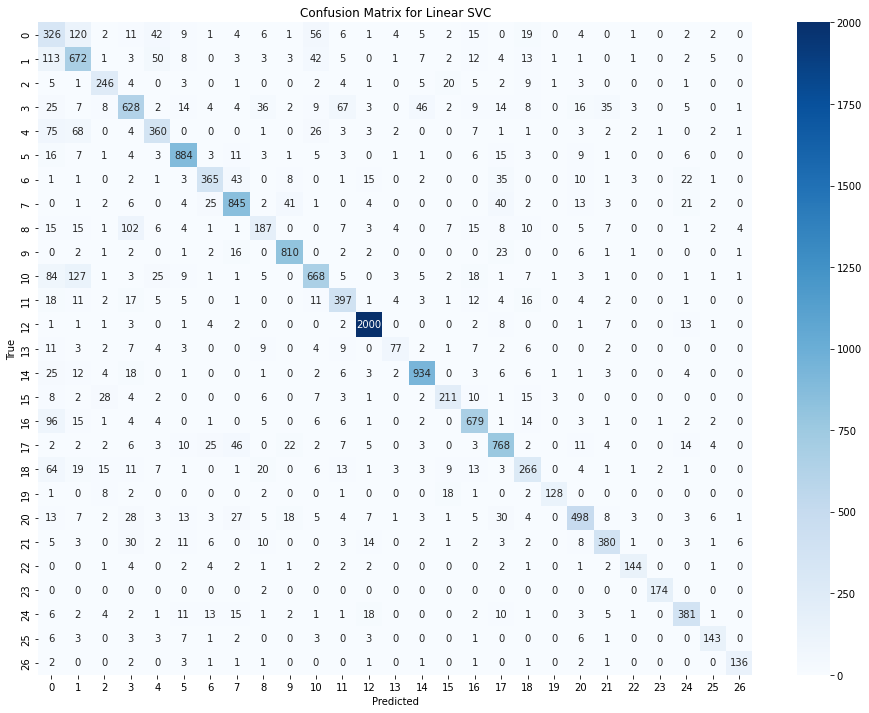

In [15]:
# Evaluate Linear SVC model
y_pred = best_lsvc.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Linear SVC:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_lsvc.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Linear SVC:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Linear SVC")
plt.show()

- **Save** the best Linear SVC model.

In [16]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best Linear SVC model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Linear SVC model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_lsvc_model.pkl"), "wb") as f:
        pickle.dump(best_lsvc, f)
    print("Best Linear SVC model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best Linear SVC model saved successfully.


###  4.7 XGBoost

To optimize the **XGBoost** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `n_estimators`: The number of boosting rounds (trees) to build. The tested values are `[50, 500]`, allowing comparison between a fast, shallow model and a deeper, more complex one.  
- `learning_rate`: The rate at which the model learns. The tested values are `[0.01, 0.2]`, where a lower value (`0.01`) results in slower but more robust learning, while a higher value (`0.2`) speeds up convergence but may risk overfitting.  

Other hyperparameters, such as `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`, and `gamma`, are left to their default values in this setup.


- **GridSearchCV** for XGBoost

In [ ]:
%%time

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 500],  # Small (50) for fast training, Large (500) for more complex learning
    'learning_rate': [0.01, 0.2]  # Small (0.01) for stable learning, Large (0.2) for faster convergence
}

# Initialize the XGBoost model
xgb = XGBClassifier()

# /!\ IMPORTANT: This cell has been updated.
# /!\ If you previously ran an older version of XGBClassifier with xgb = XGBClassifier(),
# /!\ you MUST re-run this cell AND all related cells (GridSearchCV, model fitting, predictions).
# /!\ This ensures the updated configuration is applied with the settings below:
# /!\ Recommended settings: use_label_encoder=False, eval_metric='mlogloss', .
xgb = XGBClassifier(
    use_label_encoder=False,  # Label s are already properly encoded (integers starting from 0, 1, 2, ...)
    eval_metric='mlogloss'    # Explicitly sets the metric to avoid a default metric warning
    # 'mlogloss' (Multiclass Log Loss) is the appropriate metric for multi-class classification
    # Before XGBoost 1.3.0, the default was 'merror', but it was changed to 'mlogloss'
)


# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_xgb = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for XGBoost: {grid_search.best_params_}")


- **Re-train** XGBoost with the best hyperparameters.

In [18]:
%%time

# After GridSearchCV has finished
# Retrain XGBoost with the best hyperparameters
best_xgb = XGBClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate']
)

# Fit the model
best_xgb.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_estimators: {grid_search.best_params_['n_estimators']}\n"
      f"learning_rate: {grid_search.best_params_['learning_rate']}")


[06:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model retrained with the following best hyperparameters:
n_estimators: 500
learning_rate: 0.2
Wall time: 17min 10s


- **Evaluate** XGBoost with the best hyperparameters.

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.32      0.64      0.42       639
           1       0.63      0.69      0.66       952
           2       0.76      0.78      0.77       313
           3       0.72      0.71      0.71       948
           4       0.80      0.63      0.70       562
           5       0.89      0.88      0.89       983
           6       0.84      0.73      0.78       514
           7       0.84      0.84      0.84      1012
           8       0.62      0.49      0.55       405
           9       0.91      0.92      0.92       870
          10       0.77      0.70      0.73       973
          11       0.76      0.75      0.75       515
          12       0.97      0.97      0.97      2047
          13       0.80      0.50      0.61       149
          14       0.95      0.90      0.92      1032
          15       0.76      0.70      0.73       303
          16       0.83      0.78      0.81   

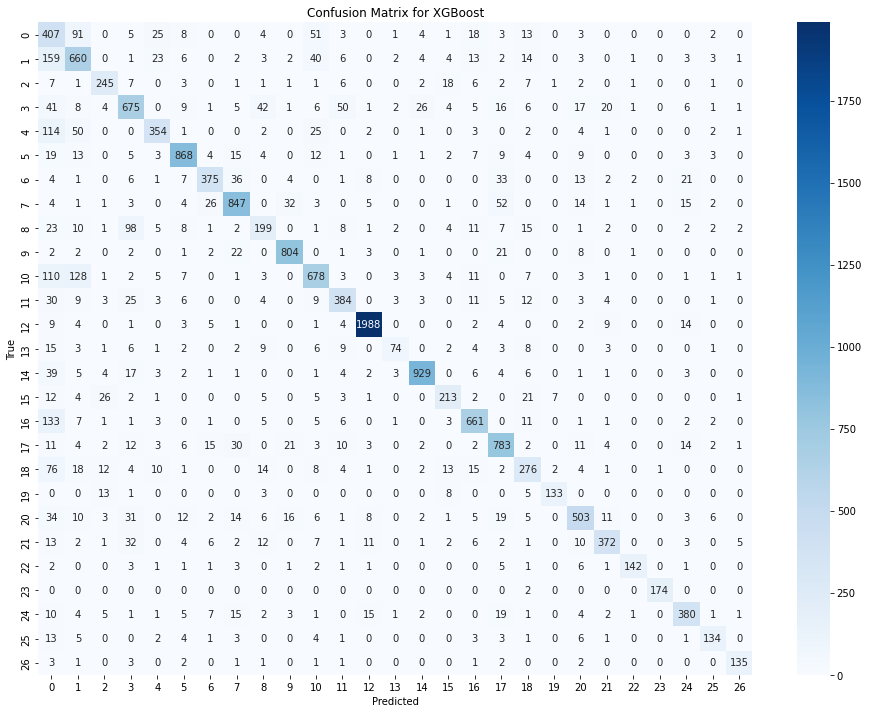

In [19]:
# Evaluate XGBoost model
y_pred = best_xgb.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_xgb.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for XGBoost:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for XGBoost")
plt.show()

- **Save** the best XGBoost model.

In [20]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Print the path where the best XGBoost model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained XGBoost model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_xgb_model.pkl"), "wb") as f:
        pickle.dump(best_xgb, f)
    print("Best XGBoost model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical
Best XGBoost model saved successfully.


## 5. Creating a Voting Classifier
- **Combine** all the best models trained in the previous steps using a **Voting Classifier**.

### Voting Classifier Strategy

The decision between **Soft Voting** and **Hard Voting** depends on whether the models in the ensemble support probability predictions (`predict_proba()`):  

- **Soft Voting** is used when all models support `predict_proba()`. Each model provides a probability distribution over the classes, and the final prediction is based on the average of these probabilities.  

- **Soft Voting with selected models** is applied when only some models support `predict_proba()`. In this case, we exclude the models that do not provide probabilities and perform Soft Voting with the remaining compatible models.  

- **Hard Voting** is used when none of the models support `predict_proba()`. Instead of averaging probabilities, Hard Voting takes the class predicted by the majority of the models.  

**Soft Voting is generally more accurate** because it considers the confidence of each model in its predictions.  
 **Hard Voting is more robust** against individual model errors but tends to be **less precise** since it relies only on the majority vote.  

**In summary, Soft Voting is preferred if all models support it. Otherwise, the strategy is adjusted based on the available model capabilities.**


###  /!\ TO REVIEW Classifier Voting V0

In [30]:
# %%time

# # List of the best models from the previous steps
# models = [
#     ('lr', best_lr),  # Logistic Regression
#     ('svm', best_svm),  # Support Vector Machine
#     ('rf', best_rf),  # Random Forest
#     ('knn', best_knn),  # K-Neighbors Classifier
#     ('dt', best_dt),  # Decision Tree
#     ('lsvc', best_lsvc),  # Linear SVC
#     ('xgb', best_xgb)  # XGBoost

# ]

# # Check if any model supports predict_proba(), which is required for soft voting
# if any([hasattr(model[1], 'predict_proba') for model in models]):
#     voting_clf = VotingClassifier(estimators=models, voting='soft')  # Soft voting
# else:
#     voting_clf = VotingClassifier(estimators=models, voting='hard')  # Hard voting

# # Train the Voting Classifier
# voting_clf.fit(X_train, y_train)

# # Optionally, save the Voting Classifier
# with open(os.path.join(config.MODELS_DIR, "voting_clf_model.pkl"), "wb") as f:
#     pickle.dump(voting_clf, f)

# print(f"Voting Classifier trained with {'soft' if voting_clf.voting == 'soft' else 'hard'} voting and saved.")


C:\anaconda_install\envs\data_science\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:17:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Voting Classifier trained with soft voting and saved.


# Handling Soft & Hard Voting Automatically

In [34]:
%%time

# [✔] List of trained models
models = [
    ('lr', best_lr),    # Logistic Regression
    ('svm', best_svm),  # Support Vector Machine
    ('rf', best_rf),    # Random Forest
    ('knn', best_knn),  # K-Nearest Neighbors
    ('dt', best_dt),    # Decision Tree
    ('lsvc', best_lsvc), # Linear SVC
    ('xgb', best_xgb)  # XGBoost
]

# [✔] Check which models support `predict_proba()` and `predict()`
models_with_proba = [m for m in models if hasattr(m[1], 'predict_proba')]
models_with_predict = [m for m in models if hasattr(m[1], 'predict')]

# [✔] Choose voting method based on model capabilities
if len(models_with_proba) == len(models):
    # All models support `predict_proba()`, use SOFT VOTING
    voting_clf = VotingClassifier(estimators=models, voting='soft')
    print("[✔] All models support `predict_proba()`. Using SOFT voting.")
elif len(models_with_proba) > 0 and len(models_with_predict) == len(models):
    # Some models do not support `predict_proba()`, remove them for SOFT VOTING
    print("/!\ Some models do not support `predict_proba()`. Using SOFT voting with compatible models only.")
    voting_clf = VotingClassifier(estimators=models_with_proba, voting='soft')
elif len(models_with_predict) == len(models):
    # No model supports `predict_proba()`, switch to HARD VOTING
    voting_clf = VotingClassifier(estimators=models, voting='hard')
    print("/!\ No model supports `predict_proba()`. Switching to HARD voting.")
else:
    raise ValueError("[X] No compatible models found for VotingClassifier. Please check your models.")

# [✔] Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# [✔] Save the trained model
voting_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "voting_clf_model.pkl")
with open(voting_model_path, "wb") as f:
    pickle.dump(voting_clf, f)

print(f"[✔] Voting Classifier trained with {'soft' if voting_clf.voting == 'soft' else 'hard'} voting and saved at {voting_model_path}")


/!\ Some models do not support `predict_proba()`. Using SOFT voting with compatible models only.


C:\anaconda_install\envs\data_science\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[✔] Voting Classifier trained with soft voting and saved at D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\voting_clf_model.pkl
Wall time: 22min 25s


- **Evaluate** Voting Classifier with the best models.

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.34      0.56      0.43       639
           1       0.62      0.70      0.66       952
           2       0.79      0.79      0.79       313
           3       0.71      0.64      0.67       948
           4       0.77      0.62      0.69       562
           5       0.88      0.90      0.89       983
           6       0.85      0.73      0.78       514
           7       0.82      0.83      0.82      1012
           8       0.62      0.50      0.55       405
           9       0.91      0.93      0.92       870
          10       0.76      0.70      0.73       973
          11       0.75      0.77      0.76       515
          12       0.96      0.98      0.97      2047
          13       0.79      0.50      0.61       149
          14       0.89      0.91      0.90      1032
          15       0.78      0.73      0.75       303
          16       0.82      0.80   

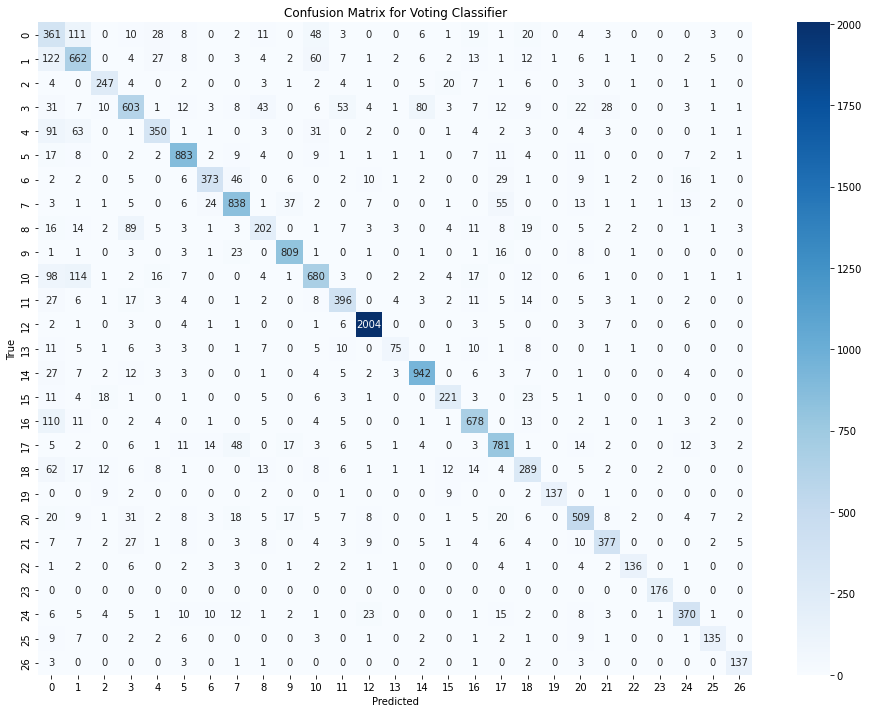

In [35]:
# Evaluate Voting Classifier model
y_pred = voting_clf.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = voting_clf.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Voting Classifier:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Voting Classifier")
plt.show()

## Reload Saved Best Models (OPTIONAL)

In [25]:
#==========================================================================================
#Load best_lr LOGISTIC REGRESSION
#==========================================================================================
# Define the full path to the saved model
lr_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.pkl")
# Check if the file exists before loading
if os.path.exists(lr_model_path):
    try:
        # Load the trained Logistic Regression model
        with open(lr_model_path, "rb") as f:
            best_lr = pickle.load(f)
        print("[✔] Best Logistic Regression model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the model: {e}")
else:
    print(f"[X] Error: Model file not found at {lr_model_path}")
    
#==========================================================================================
#Load  SVM MODEL
#==========================================================================================
# Define the full path to the saved SVM model
svm_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_svm_model.pkl")

# Check if the file exists before loading
if os.path.exists(svm_model_path):
    try:
        # Load the trained SVM model
        with open(svm_model_path, "rb") as f:
            best_svm = pickle.load(f)
        print("[✔] Best SVM model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the SVM model: {e}")
else:
    print(f"[X] Error: SVM model file not found at {svm_model_path}")

    
#==========================================================================================
# Load RANDOM FOREST MODEL
#==========================================================================================
# Define the full path to the saved Random Forest model
rf_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_rf_model.pkl")

# Check if the file exists before loading
if os.path.exists(rf_model_path):
    try:
        # Load the trained Random Forest model
        with open(rf_model_path, "rb") as f:
            best_rf = pickle.load(f)
        print("[✔] Best Random Forest model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the Random Forest model: {e}")
else:
    print(f"[X] Error: Random Forest model file not found at {rf_model_path}")
    
#==========================================================================================
# Load KNN  MODEL
#==========================================================================================
# Define path
knn_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_knn_model.pkl")

# Load model
if os.path.exists(knn_model_path):
    try:
        with open(knn_model_path, "rb") as f:
            best_knn = pickle.load(f)
        print("[✔] Best KNN model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the KNN model: {e}")
else:
    print(f"[X] Error: KNN model file not found at {knn_model_path}")

#==========================================================================================
# Load DECISION TREE  MODEL
#==========================================================================================
# Define path
dt_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_dt_model.pkl")

# Load model
if os.path.exists(dt_model_path):
    try:
        with open(dt_model_path, "rb") as f:
            best_dt = pickle.load(f)
        print("[✔] Best Decision Tree model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the Decision Tree model: {e}")
else:
    print(f"[X] Error: Decision Tree model file not found at {dt_model_path}")


#==========================================================================================
# Load Linear SVC model
#==========================================================================================
# Define path
lsvc_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lsvc_model.pkl")

# Load model
if os.path.exists(lsvc_model_path):
    try:
        with open(lsvc_model_path, "rb") as f:
            best_lsvc = pickle.load(f)
        print("[✔] Best Linear SVC model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the Linear SVC model: {e}")
else:
    print(f"[X] Error: Linear SVC model file not found at {lsvc_model_path}")
    
#==========================================================================================
# Load XGBoost model
#==========================================================================================
# Define path
xgb_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_xgb_model.pkl")

# Load model
if os.path.exists(xgb_model_path):
    try:
        with open(xgb_model_path, "rb") as f:
            best_xgb = pickle.load(f)
        print("[✔] Best XGBoost model loaded successfully.")
    except Exception as e:
        print(f"[X] Error: XGBoost model file not found at {xgb_model_path}")

#==========================================================================================
# Load Voting Classifier
#==========================================================================================
# Define path
vc_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "voting_clf_model.pkl")
# Load model
if os.path.exists(vc_model_path):
    try:
        with open(vc_model_path, "rb") as f:
            voting_clf = pickle.load(f)
        print("[✔] Voting Classifier model loaded successfully.")
    except Exception as e:
        print(f"[X] Error: Voting Classifier model file not found at {vc_model_path}")

[✔] Best Logistic Regression model loaded successfully.
[✔] Best SVM model loaded successfully.
[✔] Best Random Forest model loaded successfully.
[✔] Best KNN model loaded successfully.
[✔] Best Decision Tree model loaded successfully.
[✔] Best Linear SVC model loaded successfully.
[✔] Best XGBoost model loaded successfully.
[✔] Voting Classifier model loaded successfully.


## 6. Model Comparison and Selection
- **Compare** the performance of each individual model and the **Voting Classifier** using metrics like the **weighted F1-score**.
- Select the best-performing model for further use or future deployment.

## Débugger les Différences Entre les Deux

In [75]:
# Sauvegarder une copie de X_test au début
if "X_test_original" not in globals():
    X_test_original = X_test.copy()

    
    # Sauvegarder une copie de y_test au début
if "y_test_original" not in globals():
    y_test_original = y_test.copy()

In [76]:
%%time

# After GridSearchCV has finished
# Retrain Logistic Regression with the best hyperparameters
clf_lr = LogisticRegression(
    multi_class= 'multinomial' ,  # Best 'multi_class' parameter
    class_weight= None,  # Best 'class_weight' parameter
    max_iter=500,  # Best 'max_iter' parameter
    # Removing 'C' and 'solver' as we're not using them in the simplified grid
)
clf_lr.fit(X_train, y_train)

# # Print the best hyperparameters used for retraining
# print(f"Model retrained with the following best hyperparameters:\n"
#       f"multi_class: {grid_search.best_params_['multi_class']}\n"
#       f"class_weight: {grid_search.best_params_['class_weight']}\n"
#       f"max_iter: {grid_search.best_params_['max_iter']}")


Wall time: 31.6 s


LogisticRegression(max_iter=500, multi_class='multinomial')

In [77]:
# Evaluate Logistic Regression model
y_pred = clf_lr.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# # Optionally, calculate other evaluation metrics like F1-Score, Accuracy
# f1 = f1_score(y_test, y_pred, average='weighted')
# accuracy = clf_lr.score(X_test, y_test)

# # Display the evaluation metrics
# print(f"Weighted F1-Score: {f1:.4f}")
# print(f"Accuracy: {accuracy:.4f}")

# # Confusion Matrix
# print("Confusion Matrix for Logistic Regression:")
# cm = confusion_matrix(y_test, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(16,12))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix for Logistic Regression")
# plt.show()



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.34      0.59      0.43       612
           1       0.58      0.73      0.65       942
           2       0.78      0.74      0.76       357
           3       0.66      0.64      0.65       961
           4       0.68      0.61      0.64       517
           5       0.88      0.90      0.89       991
           6       0.76      0.70      0.73       462
           7       0.83      0.83      0.83      1013
           8       0.62      0.43      0.51       424
           9       0.90      0.92      0.91       841
          10       0.77      0.68      0.72       986
          11       0.72      0.74      0.73       539
          12       0.95      0.97      0.96      2047
          13       0.74      0.47      0.58       146
          14       0.88      0.88      0.88       974
          15       0.77      0.71      0.74       306
          16       0.80      0.79 

In [78]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the full path for saving the model
model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.joblib")

# Print where the model will be saved
print(f"Saving the model to: {model_path}")

try:
    # Save the trained Logistic Regression model using joblib
    dump(clf_lr, model_path)
    print("[✔] Best Logistic Regression model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"[X] Error occurred while saving the model: {e}")

Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_lr_model.joblib
[✔] Best Logistic Regression model saved successfully.


In [79]:
#==========================================================================================
#Load best_lr LOGISTIC REGRESSION
#==========================================================================================
# Define the full path to the saved model
lr_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.joblib")

# Check if the file exists before loading
if os.path.exists(lr_model_path):
    try:
        # Load the trained Logistic Regression model using joblib
        best_lr = load(lr_model_path)
        print("[✔] Best Logistic Regression model loaded successfully.")
    except Exception as e:
        print(f"[X] Error loading the model: {e}")
else:
    print(f"[X] Error: Model file not found at {lr_model_path}")
    

[✔] Best Logistic Regression model loaded successfully.


#Vérifier les hyperparamètres

In [80]:
print("Initial model parameters:", clf_lr.get_params())
print("Loaded model parameters:", best_lr.get_params())

if clf_lr.get_params() == best_lr.get_params():
    print("[✔] Les hyperparamètres sont identiques.")
else:
    print("[X] Problème : les hyperparamètres ont changé après chargement !")


Initial model parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Loaded model parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[✔] Les hyperparamètres sont identiques.


In [81]:
%%time

# # Create a dictionary to store the models and their respective predictions
# models = {
#     'Logistic Regression': best_lr,
#     'SVM': best_svm,
#     'Random Forest': best_rf,
#     'K-Neighbors': best_knn,
#     'Decision Tree': best_dt,
#     'Linear SVC': best_lsvc,
#     'XGBoost': best_xgb,   
#     'Voting Classifier': voting_clf  # The Voting Classifier
# }

models = {
    'Logistic Regression': best_lr,
#     'SVM': best_svm #,
#     'Random Forest': best_rf,
#     'K-Neighbors': best_knn,
#     'Decision Tree': best_dt,
#     'Linear SVC': best_lsvc,
#     'XGBoost': best_xgb,   
#     'Voting Classifier': voting_clf  # The Voting Classifier
}

# Initialize an empty dictionary to store the weighted F1 scores
f1_scores = {}

# Compare the performance of each model on the test set
for model_name, model in models.items():
    # Make predictions using the model
    y_pred_best_model = model.predict(X_test)

    

#     # Calculate the weighted F1-score for the model
#     f1 = f1_score(y_test, y_pred, average='weighted')
#     f1_scores[model_name] = f1

    # Print the classification report for each model
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred_best_model))

# # Select the best-performing model based on the weighted F1-score
# best_model_name = max(f1_scores, key=f1_scores.get)
# best_model = models[best_model_name]

# print(f"\nBest model based on weighted F1-score: {best_model_name} with a score of {f1_scores[best_model_name]:.4f}")


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.34      0.59      0.43       612
           1       0.58      0.73      0.65       942
           2       0.78      0.74      0.76       357
           3       0.66      0.64      0.65       961
           4       0.68      0.61      0.64       517
           5       0.88      0.90      0.89       991
           6       0.76      0.70      0.73       462
           7       0.83      0.83      0.83      1013
           8       0.62      0.43      0.51       424
           9       0.90      0.92      0.91       841
          10       0.77      0.68      0.72       986
          11       0.72      0.74      0.73       539
          12       0.95      0.97      0.96      2047
          13       0.74      0.47      0.58       146
          14       0.88      0.88      0.88       974
          15       0.77      0.71      0.74       306
          16       0.80      0.79

In [82]:
# Vérifier si y_pred_best_model vient bien du Logistic Regression
y_pred_lr = clf_lr.predict(X_test)

# Comparer les prédictions
if (y_pred_lr == y_pred_best_model).all():
    print("[✔] y_pred_best_model est bien issu de clf_lr.")
else:
    print("[X] Problème : y_pred_best_model est différent de y_pred_lr !")
    print(f"Nombre de différences : {(y_pred_lr != y_pred_best_model).sum()}")


[✔] y_pred_best_model est bien issu de clf_lr.


In [92]:

# # Assurer que X_test et X_test_original sont des numpy arrays avant la comparaison
# X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test
# X_test_original_dense = X_test_original.toarray() if hasattr(X_test_original, "toarray") else X_test_original

# # Comparer les dimensions
# print(f"Taille de X_test avant évaluation : {X_test_original_dense.shape}")
# print(f"Taille de X_test maintenant : {X_test_dense.shape}")

# # Comparer les valeurs
# if (X_test_original_dense == X_test_dense).all():
#     print("[✔] X_test est identique avant et après évaluation.")
# else:
#     print("[X] Problème : X_test a changé après la première évaluation !")
# #     print(f"Nombre de différences : {(X_test_original_dense != X_test_dense).sum()}")

# Comparer l'état actuel de y_test avec la version initiale
print(type(y_test_original))
print(type(y_test))
if (y_test_original.values == y_test.values).all():
    print("[✔] y_test est identique dans les deux évaluations.")
else:
    print("[X] Problème : y_test a changé entre les deux évaluations !")
    print(f"Taille de y_test_original: {y_test_original.shape[0]}")
    print(f"Taille de y_test: {y_test.shape[0]}")
    print("10 premiers éléments de y_test_original:", y_test_original[:5])
    print("10 premiers éléments de y_test:", y_test[:5])
#     print(f"Nombre de différences : {(y_test_original != y_test).sum()}")


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
[X] Problème : y_test a changé entre les deux évaluations !
Taille de y_test_original: 16984
Taille de y_test: 16984
10 premiers éléments de y_test_original: 4386     16
75415     2
7484      1
47083     9
31744     2
Name: prdtypecode, dtype: int64
10 premiers éléments de y_test: 36138    23
68630     8
36172    17
9830      3
28422     1
Name: prdtypecode, dtype: int64


In [87]:
import numpy as np
import pandas as pd

#===========================
# Example 1: Identical Series
#===========================
y_test_original_1 = pd.Series([0, 1, 2, 3, 4, 5])
y_test_1 = pd.Series([0, 1, 2, 3, 4, 5])

if (y_test_original_1.values == y_test_1.values).all():
    print("[✔] y_test est identique dans les deux évaluations. ✅ (Example 1)")
else:
    print("[X] Problème : y_test a changé entre les deux évaluations ! ❌ (Example 1)")

#===========================
# Example 2: Different Series
#===========================
y_test_original_2 = pd.Series([0, 1, 2, 3, 4, 5])
y_test_2 = pd.Series([0, 1, 2, 3, 4, 6])  # Le dernier élément est différent

if (y_test_original_2.values == y_test_2.values).all():
    print("[✔] y_test est identique dans les deux évaluations. ✅ (Example 2)")
else:
    print("[X] Problème : y_test a changé entre les deux évaluations ! ❌ (Example 2)")


[✔] y_test est identique dans les deux évaluations. ✅ (Example 1)
[X] Problème : y_test a changé entre les deux évaluations ! ❌ (Example 2)


### Display the Mapping Between Encoded Labels and Original Classes
Before saving the best model, let's display the correspondence between the **encoded labels** (0-26) and their **original classes**. This will help us understand the mapping of the product categories in the context of our model's predictions.

In [42]:
# Print the path where the label mapping file will be loaded from
print(f"Loading the label mapping from: {config.PRDTYPECODE_MAPPING_PATH}")

try:
    # Load the label mapping from the pickle file (Encoded Label → Original Class)
    with open(config.PRDTYPECODE_MAPPING_PATH, 'rb') as f:
        prdtypecode_mapping = pickle.load(f)

    # The DataFrame has already the three columns: "Original prdtypecode", "Encoded target", and "Label"
    mapping_df = prdtypecode_mapping  # Since it's already a DataFrame

    # Display the first 5 rows of the DataFrame after loading
    print("Label mapping loaded from pickle file:")
    print(mapping_df.head())

    # Predict using the best model (selected based on weighted F1-score)
    y_pred_best_model = best_model.predict(X_test)  # Make predictions with the best model

    # Create a DataFrame to display the classification report and results for each class
    classification_results = classification_report(y_test, y_pred_best_model, output_dict=True)
    classification_results_df = pd.DataFrame(classification_results).transpose()

    # Merge the classification results with the mapping
    classification_results_with_mapping = pd.merge(classification_results_df, mapping_df, 
                                                   left_index=True, right_on="Encoded target", how="left")

    # Display the table showing classification results and the corresponding classes
    print("Classification Report with Encoded Labels and Their Original Classes:\n")
    print(classification_results_with_mapping)

except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while loading the label mapping: {e}")


Loading the label mapping from: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\data\processed\text\prdtypecode_mapping.pkl
Label mapping loaded from pickle file:
   Original prdtypecode  Encoded target                    Label
0                    10               0              Adult Books
1                  2280               1                Magazines
2                    50               2  Video Games Accessories
3                  1280               3        Toys for Children
4                  2705               4                    Books

Error occurred while loading the label mapping: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat


## 7. Saving the Best Model 
- **Save** the best model (Voting Classifier or other) for future use and potential deployment.

In [ ]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path where the best model will be saved
best_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_model.pkl")
print(f"Saving the best model to: {best_model_path}")

try:
    # Try to save the best model (Voting Classifier or another model)
    with open(best_model_path, "wb") as f:
        pickle.dump(best_model, f)
    print(f"The best model has been saved successfully at: {best_model_path}")
except Exception as e:
    # In case of an error, print the error message
    print(f"Error occurred while saving the best model: {e}")


## 8. Analyzing Model Predictions Performed by the Best Model  

We will **analyze its classification performance** to better understand its strengths and weaknesses.  

 

### **⚠ Reminder: Baseline Model Performance**   
The baseline model for text-based classification (**RNN**) achieved a **0.8113 weighted F1-score**.  

---

### **Classification Thresholds Used in This Analysis**  
- Categories with an **F1-score above 0.80** are considered well-classified as they meet or exceed the baseline.  
- **Moderately classified categories** fall between **0.50 and 0.80**, indicating areas where optimization could enhance performance.  
- **Categories scoring below 0.50** are significantly underperforming and require targeted improvements, such as better feature engineering, different model architectures, or additional data preprocessing.  

By analyzing these classification patterns, we can **identify potential imbalances, misclassifications, or areas for refinement** to improve overall model performance.


In [ ]:
import ace_tools as tools  # Ensure ace_tools is enabled

#  Extract classification metrics for each class
classification_results = classification_report(y_test, y_pred_best_model, output_dict=True)
classification_df = pd.DataFrame(classification_results).transpose()

#  Merge with the label mapping to get original product code classes
classification_df = pd.merge(classification_df, mapping_df, 
                             left_index=True, right_on="Encoded target", how="left")

#  Categorize classes based on F1-score performance
well_detected = classification_df[classification_df["f1-score"] > 0.80]
moderately_detected = classification_df[(classification_df["f1-score"] >= 0.50) & (classification_df["f1-score"] <= 0.80)]
poorly_detected = classification_df[classification_df["f1-score"] < 0.50]

#  Display statistics on classification performance
print(f"Well-classified categories (F1-score > 80): {len(well_detected)}")
print(f"Moderately classified categories (50 ≤ F1-score ≤ 80): {len(moderately_detected)}")
print(f"Poorly classified categories (F1-score < 50): {len(poorly_detected)}")

# Display well-classified categories
print("\nWell-classified categories:")
tools.display_dataframe_to_user(name="Well-Classified Categories", dataframe=well_detected)

#  Display moderately classified categories
print("\nModerately classified categories:")
tools.display_dataframe_to_user(name="Moderately Classified Categories", dataframe=moderately_detected)

#  Display poorly classified categories
print("\nPoorly classified categories:")
tools.display_dataframe_to_user(name="Poorly Classified Categories", dataframe=poorly_detected)


## 9. Conclusion  

## 10. 🔄 Next Steps

Having explored classical machine learning models for text classification, it's imperative to assess more advanced neural network architectures to enhance performance, we focused on the following models:

- **RNN with GRU Cell (RNN-GRUCell)**: This architecture provides granular control over each time step in sequential processing, which is particularly beneficial for custom architectures or research requiring fine manipulation of recurrent states.

- **Bidirectional Long Short-Term Memory Network (BiLSTM)**: BiLSTMs process data in both forward and backward directions, capturing past and future dependencies in a sequence, thereby offering a richer contextual understanding.

- **1D Convolutional Neural Network (Conv1D)**: Conv1D layers are effective in extracting local patterns in sequential data, identifying specific combinations of words or phrases indicative of certain classes.

- **Deep Neural Network (DNN)**: Comprising multiple fully connected layers, DNNs are powerful in modeling complex relationships within data, especially when combined with feature extraction techniques like word embeddings or TF-IDF representations.

Evaluating these advanced models aims to determine whether they surpass classical approaches in our specific text classification task. 
As time and resources permit, we will consider exploring additional approaches to further enhance our model's performance.

Continue with the next notebook:  
*`notebooks/modeling/9_RNN_with_GRU_Cell_for_Text_Classification.ipynb`*